In [1]:
import os
import json

import torch

from rnn_model import LSTMNet, GRUNet
from utils import DotDict, Logger, rmse, rmse_tensor, boolean_string, get_dir, get_time, next_dir, model_dir, get_model
from get_data import dataset_factory, get_data_set
from stnn import SaptioTemporalNN
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
%load_ext autoreload
%autoreload 2
from result import *

## Data

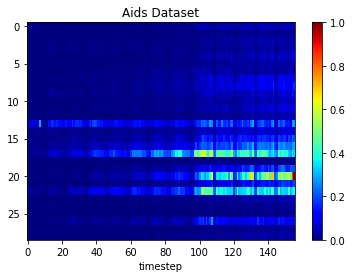

In [3]:
datadir = 'data'
dataset = 'aids'
_, data = get_data_set(datadir, dataset)

plt.figure('Aids Dataset')
plt.imshow(data.squeeze().numpy().T, aspect='auto', cmap='jet')
plt.title('Aids Dataset')
plt.xlabel('timestep')
plt.colorbar()

## Mode List

In [4]:
folder = os.path.abspath(os.path.join(os.getcwd(), '..', 'output', 'aids_default'))
stnn = Printer(folder)

In [5]:
print("Model List : ")
stnn.models()

Model List : 


['test_15-59-28-11-37']

In [6]:
stnn.get_df(mean=True, min=True)

,test_loss,train_loss,nhid,nlayers
test_15-59-28-11-37,0.16229,41.351869,0.0,1.0
mean,0.16229,41.351869,0.0,1.0
min,0.16229,41.351869,0.0,1.0


In [7]:
stnn.min_idx()

the df is :
                     test_loss  train_loss  nhid  nlayers
test_15-59-28-11-37    0.16229   41.351869     0        1


'test_15-59-28-11-37'

## Exp 

In [8]:
exp_name = 'test_15-59-28-11-37'

In [9]:
exp = Exp(exp_name, folder)

D:\Jupyter_Documents\ML-code\research_code\output\aids_default
test_15-59-28-11-37


In [10]:
exp.model()

SaptioTemporalNN(
  (drop): Dropout(p=0.5)
  (dynamic): MLP(
    (module): Linear(in_features=2, out_features=1, bias=True)
  )
  (decoder): Linear(in_features=1, out_features=1, bias=False)
)

In [11]:
pred = exp.pred()

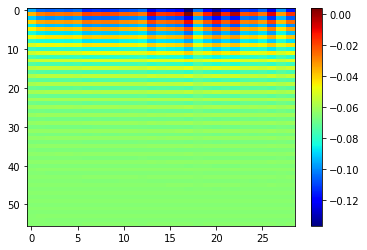

In [12]:
plt.imshow(pred, aspect='auto', cmap='jet')
plt.colorbar()

In [13]:
for name, params in exp.model().named_parameters():
    print(name, params)

factors Parameter containing:
tensor([[[ 0.0099],
         [ 0.0249],
         [ 0.0392],
         ...,
         [ 0.0437],
         [-0.0005],
         [ 0.0444]],

        [[ 0.0772],
         [ 0.1556],
         [ 0.1037],
         ...,
         [ 0.1287],
         [ 0.0983],
         [ 0.0770]],

        [[ 0.0647],
         [ 0.1048],
         [ 0.1077],
         ...,
         [ 0.1034],
         [ 0.1033],
         [ 0.0688]],

        ...,

        [[ 0.0883],
         [ 0.0926],
         [ 0.1002],
         ...,
         [ 0.0303],
         [ 0.1118],
         [ 0.0669]],

        [[ 0.0490],
         [ 0.0659],
         [ 0.0504],
         ...,
         [ 0.0868],
         [ 0.0484],
         [ 0.0831]],

        [[ 0.1118],
         [ 0.0729],
         [ 0.0642],
         ...,
         [-0.0198],
         [ 0.0960],
         [ 0.0166]]], requires_grad=True)
dynamic.module.weight Parameter containing:
tensor([[-0.9505, -0.0173]], requires_grad=True)
dynamic.module.bias Paramet

In [ ]:
exp

## Aids LSTM

In [8]:
folder_name = 'aids_LSTM'
model_name = get_model(folder_name)[1]
model_list = model_dir[folder_name]

### The Best Model 

In [ ]:
for model in model_list:
    model = LSTMNet()

In [5]:
outputdir = 'output'
exps = ['stnn']
models = {}
for exp in exps:
    with open(os.path.join(outputdir, exp, 'config.json'), 'r') as f:
        config = json.load(f)
    setup, (train_input, train_output), (test_input, test_data)  = dataset_factory(datadir, dataset, 700, 5)
    model = rnn(29, config['nhid'], config['nlayers'], 29, config['seq_length'])
    state_dict = torch.load(os.path.join(outputdir, exp, 'model.pt'), map_location=lambda storage, loc: storage)
    model.load_state_dict(state_dict)
    models[exp] = model

## Results

In [6]:
predictions = {}
for exp in exps:
    model = models[exp]
    model.eval()
    with torch.no_grad():
        prediction = model.generate(test_input, 396)
        predictions[exp] = prediction
        mse =  rmse(prediction, test_data)
        print(prediction.size())
    print('RMSE {}:\t'.format(exp), mse)

torch.Size([396, 29, 1])
RMSE stnn:	 9.350045204162598


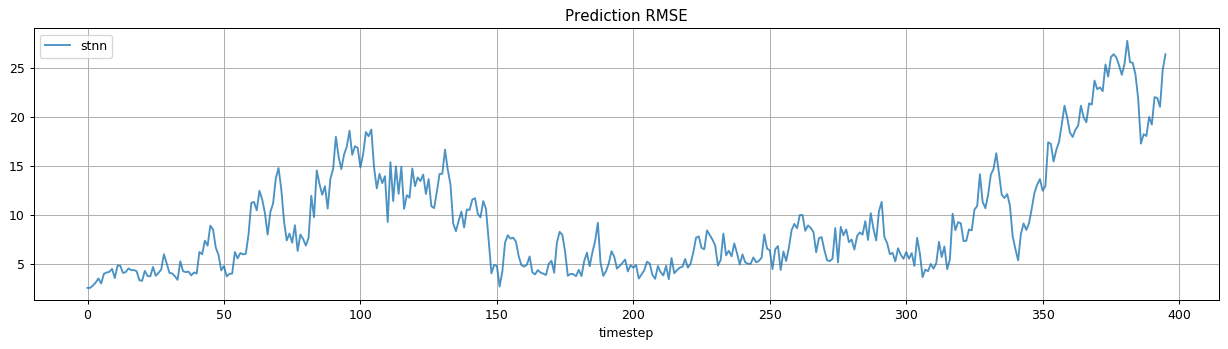

In [7]:
plt.figure('Test plots', figsize=(17, 4), dpi=90)
for exp in exps:
    with open(os.path.join(outputdir, exp, 'logs.json'), 'r') as f:
        logs = json.load(f)

    plt.plot([logs['test_epoch.ts.{}.rmse'.format(ts)][-1] for ts in range(396)], label=exp, alpha=0.8)

plt.grid()
plt.title('Prediction RMSE')
plt.xlabel('timestep')
plt.legend()

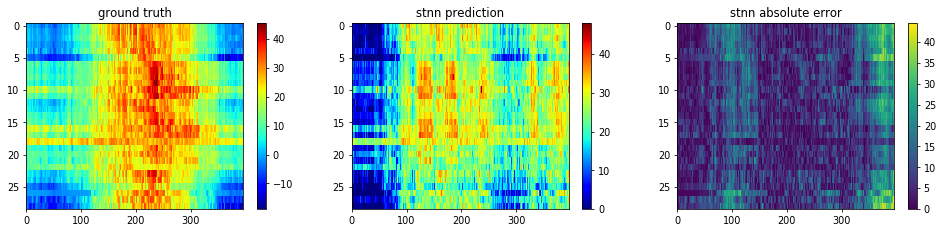

In [8]:
plt.figure('Results', figsize=(17, 12), dpi=70)

plt.subplot(3, 3, 1)
plt.imshow(test_data.squeeze().numpy().T, aspect='auto', cmap='jet')
plt.colorbar()
plt.title('ground truth')

for i, exp in enumerate(exps):
    plt.subplot(3, 3, i * 3 + 2 + i // 3)
    plt.imshow(predictions[exp].squeeze().numpy().T, aspect='auto', cmap='jet')
    plt.colorbar()
    plt.title('{} prediction'.format(exp))

    plt.subplot(3, 3, i * 3 + 3 + i // 3)
    plt.imshow(test_data.sub(predictions[exp]).abs().squeeze().numpy().T, aspect='auto')
    plt.colorbar()
    plt.title('{} absolute error'.format(exp))